# Tutorial: processing scanning 3DXRD data using Friedel Pairs 
## Introduction

scanning 3-dimensional X-ray Diffraction (s3DXRD), or point-focused High Energy Diffraction Microscopy(pf-HEDM) is a variation of the 3DXRD/HEDM technique (Poulsen, 2004) to map crystallographic orientation and strain within a 3D volume. It uses a pencil-beam setup, where the sample is translated and rotated multiple times in order to successively illuminate different sub-volume of the sample with the incident beam. Although the acquisition time is significantly increased compared to regular 3DXRD/HEDM with a larger line-focus or box beam, s3DXRd provides much richer information on the internal crystal orientation and strain field. It allows complete reconstruction of the grain shapes, and theoretically allows to map intra grain variations of orientation and strain. However, processing 3DXRD data can be long and tedious, and the "normal" procedure involving grain fitting and reconstruction from the sinogram of data can appear somewhat non-intuitive. 

An alternative procedure has been developped (Jacob et al., submitted), which exploits the symmetric properties of Friedel pairs to process s3DXRD datasets. Friedel pairs are symmetric reflections (h,k,l) and (-h,-k,-l) arising from the same grain, which occur at 180° offset during a full 360° rotation of the sample along an axis perpendicular to the beam. Using the symmetric properties of these pairs, it is possible to clearly seperate the component of the apparent diffraction vectors related to lattice orientation and spacing (the "true" diffraction vector) from the component related to spatial offset from the rotation centre (which provides information on the position of the diffracting source in the sample). Identifying Friedel pairs in a 3DXRD dataset thus enables to treat indexing and grain position fitting as two independant problems, which considerably simplifies data analysis, in particular in complex samples such as polyphased, highly strained polycrystaline materials. 


This tutorial aims to guide you step-by-step to obtain an indexed grain map starting from segmented diffraction peaks, using the Friedel pair method. More detailed information about the method can be found in the associated publication (Jacob et al. submitted). 


#### Requirements:

##### Software
- a functional python environment (3.9 or above) installed on your machine, with jupyter notebooks. If you use the ESRF Nice cluster, it should be allright
- ImageD11 module to process 3D X-ray diffraction data. Check here for details on installation:  https://github.com/FABLE-3DXRD/ImageD11 

#### Data acquisition & pre-processsing
- data acquisition must be done applying full 360° rotations of the sample along the z-axis (vertical), in order to get symmetric (h,k,l) and (-h,-k,-l) reflections. Regular 180° scans are not suitable for the Friedle Pairs technique.
- the raw diffraction frames have been segmented into discrete diffraction peaks and stored in a peak table (check the notebook 0S3DXRD_segment_and_label.ipynb here: https://github.com/FABLE-3DXRD/ImageD11/tree/master/ImageD11/nbGui/S3DXRD).
- A dataset file (ImageD11.sinograms.dataset) containing information about range and step size of scanning (ystep, ybins, obins, etc.) has been computed
- detector has been properly calibrated, with calibration parameters (tilt, center, distance, etc.) stored in a ImageD11 parameter file (*.par)


#### Example dataset
Example datasets are provided in the folder /data

SI3_DT360Z5480 is a slice of granite scanned at the 3DXRD station of ID11 (ESRF), using a 50x50 µm pencil beam and angular steps of 0.8°. It contains a diverse mineral assemblage consisting of quartz, biotite, orthoclase (K-feldspar), oligoclase (Plagioclase) and magnetite. Peak segmentation was done using old, deprecated code and has no peak table assigned, so only a peakfile (ImageD11 columnfile saved in hdf format) is provided. This dataset is relatively small and it should be possible to process it on a personal machine without crashing. For large high-resolution datasets, access to a computer cluster with >100 GB active memory is probably necessary.

The dataset SI3_DT360Z5480 includes: 
- a peakfile containing 3D peaks (merged in omega): SI3_DT360Z5480_pk3d.h5
- metadata stored in an ImageD11.sinogram.dataset object: SI3_DT360Z5480_ds.h5 
- a parameter file containing detector calibration parameters: SI3.par
In addition, crystal structures for all the minerals mentioned above are provided as cif files in the /cif folder.

other datasets to come (to show how to process data starting from a peaktable)...


## Summary
This tutorial is divided into five parts, corresponding to different notebooks:

- Tuto_001_Friedel_Pairs_Match.ipynb: Find Friedel pairs in a set of segmented peaks, assign them a label and store the paired peaks in a new ImageD11 columnfile

- Tuto_002_Phase_Labelling.ipynb: Point-by-point phase labeling. Map peaks to pixels on a 2D map and find the best-matching phase for each pixel, from a list of pre-determined crystal structures. Also filter peaks in the peakfile and assign them a phase label.

- Tuto_003_Local_Indexing.ipynb: Point-by-point fitting of the real-space lattice vectors ($UBI$ matrix) on each pixel of the map

- 004_Grain_Mapping_DBSCAN: A simple grain-mapping strategy using the DBscan algorithm to find grains by clustering pixels in symmetry-reduced orientation space. Inspired from orix (https://orix.readthedocs.io/en/latest/tutorials/clustering_across_fundamental_region_boundaries.html). Read Johnstone et al. 2020 (https://arxiv.org/abs/2001.02716) for more details.

- Tuto_005_Strain_Stress_Mapping.ipynb: Map strain and stress to pixels and grains


In addition, shorter notebooks (without the 'Tuto' prefix) are provided, with less detailed explanation. They aim to serve as a starting base to build your processing workflow.

# Part 1: Friedel Pairs Matching

The first part of the process consists in finding friedel pairs among the set of segmented diffraction peaks. Each pair will be given a unique label, so they can be rapidly identified in subsequent steps. 

### load packages

In [ ]:
# general modules
import os, sys
import h5py
import pylab as pl
import numpy as np

# ImageD11 https://github.com/FABLE-3DXRD/ImageD11
import ImageD11.sinograms.dataset
import ImageD11.sinograms.properties
import ImageD11.sparseframe
import ImageD11.blobcorrector
import ImageD11.columnfile


# point-fit 3dxrd module available at https://github.com/jbjacob94/pf_3dxrd.
# Not yet installable with pip, just copy + paste the files into your working folder 

if '/home/esrf/jean1994b/' not in sys.path:
    sys.path.append('/home/esrf/jean1994b/')
    
from pf_3dxrd import utils, friedel_pairs, crystal_structure

%matplotlib ipympl
%load_ext autoreload
%autoreload 2

### Loading data
Recent dataset (post-2023) acquired at beamline ID11 should consist in a peak table (*_peaks_table.h5) containing 2D peaks segmented from 2D diffraction frames, 3D peaks merged in omega, and labels to relate 2D peaks to 3D peaks ("spot3D_id"). Metadata with file paths, acquisition parameters (rotation and translation steps, etc.), are stored in a "Dataset" file (*_dataset.h5). For dataset SI3_DT360Z5480, 3D spots are directly provided as an ImageD11 columnfile. If you wish to start your processing from a peakfile (ImageD11 columnfile), this can be precised in the load_data function (input_format = 'peakfile').

The first step consists in loading these data and storing peaks in a columnfile object. 

#### should I use 2D or 3D peaks?
2D peaks are raw peaks segmented from the 2D detector images, while 3D peaks are peaks segmented in the 3D space ($y_{det}$, $z_{det}$, $\omega$). Friedel pair search can be done on both. In my experience, working with 2D peaks provides better results for the point-by-point fit of orientations, especially for large grains with low misorientation. However, it is at the expense of (much) larger memory requirement and longer computation time than merged 3D peaks, because the number of peaks to match is much larger. For the SI3_DT360Z5480 dataset in this tutorial, only 3D peaks are available.

In [3]:
def load_data(dsname, parfile, input_format = 'peaktable', return_2D_peaks=False):
    """ 
    load data from peakfile or peaktable 
    
    Args:
    ----------
    dsname (str) : dataset name
    parfile (str): parameter file name
    input_format (str) : either 'peaktable' or 'peakfile'. Control whether data is loaded from an ImageD11 peak table or from a simple peakfile 
    return_2D_peaks (bool): returns 2D peaks instead of 3D peaks (merged in omega) are returned. Only relevant for data loaded from a peak table
                            default is False
    
    Returns:
    cf : ImageD11 columnfile
    ds : ImageD11 dataset
    """
    ####################################
    assert input_format in ['peakfile', 'peaktable'], 'input_format must be either "peakfile" or "peaktable" '
    
    # paths
    ####################################
    if input_format == 'peaktable':
        pksfile = os.path.join(data_dir, dsname+'_peaks_table.h5')
        dsfile  = pksfile.replace('peaks_table','dataset')
    else:
        pksfile = os.path.join(data_dir, dsname+'_pks.h5') 
        dsfile  = pksfile.replace('pks','dataset')
   
    
    # load ds file and peaks dictionary
    ####################################
    ds = ImageD11.sinograms.dataset.load(dsfile)

    print(f'Loading data for dataset {ds.dsname}: \n==============================')    
    items = 'n_ystep,n_ostep,ymin,ymax,ystep,omin,omax,ostep'.split(',')
    vals  = [ds.shape[0], ds.shape[1], ds.ymin, ds.ymax, ds.ystep, ds.omin, ds.omax, ds.ostep]
    for i,j in zip(items, vals):
        print(f'{i}: {j:.1f}')
        
    print('==============================')
        
    if input_format == 'peakfile':
        print('loading peakfile...')
        pks = ImageD11.columnfile.columnfile(pksfile)
        pkd = {t:pks.getcolumn(t) for t in pks.titles}
         
    else:
        print('loading peaks from peak table...')
        pkst = ImageD11.sinograms.properties.pks_table.load(pksfile)
        
        print('merging peaks...')
        if return_2D_peaks:      
            pkd = pkst.pk2d( ds.omega, ds.dty )         # for 2D peaks
        else:
            pkd = pkst.pk2dmerge( ds.omega, ds.dty )  # for 3D peaks
            
    cf = ImageD11.columnfile.colfile_from_dict(pkd)
    print(f'loaded peakfile: nrows = {cf.nrows}')
    utils.get_colf_size(cf)
    
    return cf, ds


In [11]:
# define paths
data_dir = 'data'

dsname = 'SI3_DT360Z5480'
parfile='data/SI3.par'
splinefile = 'data/frelon21_mar16.spline'


# load data
cf, ds = load_data(dsname, parfile, input_format='peakfile')

Loading data for dataset SI3_DT360Z5480: 
n_ystep: 109.0
n_ostep: 450.0
ymin: -2.7
ymax: 2.7
ystep: 0.1
omin: 0.0
omax: 360.0
ostep: 0.8
loading peakfile...
Reading your columnfile in hdf format
loaded peakfile: nrows = 4104546
Total size =  109.60 MB


Let's have a look at loaded data. 

In [12]:
print(cf.titles)

['omega', 's_raw', 'f_raw', 'sum_intensity', 'spot3d_id', 'dty', 'number_of_pixels']


The peakfile should contain the following  columns: omega, s_raw, f_raw, sum_intensity, spot3d_id, dty and number_of_pixels. omega is the rotation angle of the sample (along the z-axis) on the diffractometer. dty is the sample translation along the y-axis (in mm or µm depending on the experimental setup). s_raw and f_raw are raw coordinates of the peak centre-of-mass on the detector. sum_intensity and number_of_pixels relate to the total peak size and intensity, and are strongly correlated. number_of_pixels is simple the total numbe rof pixels integrated in each peak, and sum_intnesity the sum of intensity of each of these pixels. 

spot3d_id is an index unique to each 3D peak, which allows to relate 2D peaks to 3D peaks in the peaks table. In our case, it is irrelevant since we are working only with 3D peaks.

### Distortion correction

Peakfile cf contains raw data columns f_raw and s_raw with raw peak coordinates on the detector. These coordinates need to be corrected for detector distortion. Different methods exist depending on the detector used for data acquisition. For the eiger detector of ID11 (nanoscope station), pre-computed distorsion images (dxfile, dyfiles) are provided, which allow fast distortion correction. For the frelon detector (3DXRD station), a splinefile is provided, from which a pixel lookup table is made, which gives the (dx,dy) correction for each pixel.

If you don't know which detector has been used, this should be precised in the dataset file. 

In [13]:
ds.detector

'frelon'

In [14]:
def correct_distortion_eiger( cf, parfile,
              dxfile="/data/id11/nanoscope/Eiger/spatial_20210415_JW/e2dx.edf",
              dyfile="/data/id11/nanoscope/Eiger/spatial_20210415_JW/e2dy.edf"):
    
    """ 
    FOR EIGER DATA. Apply detector distortion correction for eiger data, using pre-computed disortion files. 
    Adds on the geometric computations (tth, eta, gvector, etc.)
    
    Args: 
    ---------
    cf : ImageD11 columnfile
    parfile (str) : parameter file
    dxfile, dyfile : detector distortion. Default files are valid for the eiger detector on the nanofocus station at ID11 
    """
    
    spat = ImageD11.blobcorrector.eiger_spatial( dxfile = dxfile, dyfile = dyfile )
    cf = ImageD11.columnfile.colfile_from_dict( spat( {t:cf.getcolumn(t) for t in cf.titles()} ) )
    cf.parameters.loadparameters(parfile)
    cf.updateGeometry()
    return cf


def correct_distortion_frelon( cf, parfile, splinefile):
    """ 
    FOR FRELON DATA. Apply detector distortion correction using a pixel look up table computed from a splinefile. 
    Adds on the geometric computations (tth, eta, gvector, etc.)
    
    Args: 
    ---------
    cf : ImageD11 columnfile
    parfile (str) : parameter file
    splinefile    : detector distortion splinefile
    detector_dim  : (X,Y) detector dimensions  
    """
    
    spat = ImageD11.blobcorrector.correctorclass(splinefile)
    
    # make pixel_lut  + substract xy grid coordinate (i,j) to keep only dx and dy arrays.
    spat.make_pixel_lut(spat.dim)
    i, j = np.mgrid[ 0:spat.dim[0], 0:spat.dim[1] ]
    dx = spat.pixel_lut[0] - i
    dy = spat.pixel_lut[1] - j
    
    # get integer pixel index (si,fi) of each peak
    si = np.round(cf['s_raw']).astype(int)
    fi = np.round(cf['f_raw']).astype(int)
    
    # apply dx dy correction on s_raw / f_raw
    sc = (dx[ si, fi ] + cf.s_raw).astype(np.float32)
    fc = (dy[ si, fi ] + cf.f_raw).astype(np.float32)
    
    # add corrected arrays as new columns
    cf.addcolumn(sc, 'sc')
    cf.addcolumn(fc, 'fc')
    
    # load parameters and update geometry
    cf.parameters.loadparameters(parfile)
    cf.updateGeometry()
    
    return cf

In [15]:
# detector correction distorsion with frelon data
cf = correct_distortion_frelon( cf, parfile, splinefile)


# detector correction distorsion with eiger data. You may want to use different dxfile/dyfile depending on 
# when and where your data were acquired. 
#cf = correct_distortion_eiger(cf, parfile)

cf.titles

['omega',
 's_raw',
 'f_raw',
 'sum_intensity',
 'spot3d_id',
 'dty',
 'number_of_pixels',
 'sc',
 'fc',
 'xl',
 'yl',
 'zl',
 'tth',
 'eta',
 'gx',
 'gy',
 'gz',
 'ds']

Several new columns have appeared. sc, fc are peak coordinates on the 2D detector after distortion correction. All other new columns relate to diffraction vectors, written in different coordinate systems:
- (xl,yl,zl) correspond to diffraction vector coordinates in the Cartesian laboratory reference frame
- (tth, eta) correspond to diffraction angles two-theta and eta (related to radial and azimuthal coordinates on the detector)
- (gx, gy, gz) correspond to coordinates of reciprocal lattice vectors, ie diffraction vectors in reciprocal space

### Pre-processing
Raw peakfiles obtained after segmentation can be quite noisy, especially if the segmentation threshold was too low to filter out all the background noise. It is usually a good idea to clean up a bit before going further in the processing pipeline. 

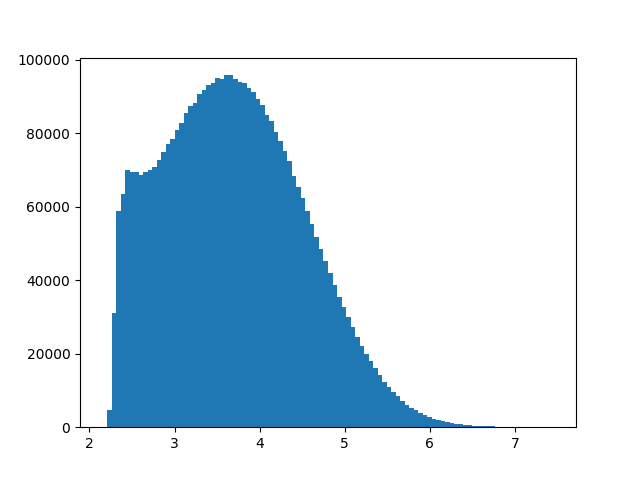

In [19]:
# look at distribution of peak intensity + nb of pixels to decide if data need to be filtered
# Here we see a sharp cut in the distribution at sum_intensity = 150, because the data have been previously filtered.

pl.figure()
pl.hist(np.log10(cf.sum_intensity),bins=100);

In [21]:
# This is how to filter data, if needed
cf.filter(cf.sum_intensity>100)
cf.filter(cf.number_of_pixels>3)   # column title might be 'Number_of_pixels' depending on the detector

cf.nrows

3863533

Friedel pairs match is found between peaks from symmetric scans (+dty;-dty) acquired at equal distance from the rotation center. We first need to form pairs of dty scans. These pairs are added to ds in ds.ypairs. 

In [21]:
# form dty pairs: pairs of (dty,-dty) scans which should contain symmetric information
friedel_pairs.form_y_pairs(cf, ds, disp=True)

dty_center =  -0.00  on bin n° 54
dty pairs: 
-0.0000 ; -0.0000
0.0500 ; -0.0500
0.1000 ; -0.1000
0.1500 ; -0.1500
0.2000 ; -0.2000
0.2500 ; -0.2500
0.3000 ; -0.3000
0.3500 ; -0.3500
0.4000 ; -0.4000
0.4500 ; -0.4500
0.5000 ; -0.5000
0.5500 ; -0.5500
0.6000 ; -0.6000
0.6500 ; -0.6500
0.7000 ; -0.7000
0.7500 ; -0.7500
0.8000 ; -0.8000
0.8500 ; -0.8500
0.9000 ; -0.9000
0.9500 ; -0.9500
1.0000 ; -1.0000
1.0500 ; -1.0500
1.1000 ; -1.1000
1.1500 ; -1.1500
1.2000 ; -1.2000
1.2500 ; -1.2500
1.3000 ; -1.3000
1.3500 ; -1.3500
1.4000 ; -1.4000
1.4500 ; -1.4500
1.5000 ; -1.5000
1.5500 ; -1.5500
1.6000 ; -1.6000
1.6500 ; -1.6500
1.7000 ; -1.7000
1.7500 ; -1.7500
1.8000 ; -1.8000
1.8500 ; -1.8500
1.9000 ; -1.9000
1.9500 ; -1.9500
2.0000 ; -2.0000
2.0500 ; -2.0500
2.1000 ; -2.1000
2.1500 ; -2.1500
2.2000 ; -2.2000
2.2500 ; -2.2500
2.3000 ; -2.3000
2.3500 ; -2.3500
2.4000 ; -2.4000
2.4500 ; -2.4500
2.5000 ; -2.5000
2.5500 ; -2.5500
2.6000 ; -2.6000
2.6500 ; -2.6500
2.7000 ; -2.7000


In each pair of y scans, each scan should have roughly the same number of peaks assigned. If not, there are two possible explanations:

- the sample is not very well aligned on the rotation center. This is not a big deal, you will just need to crop out the data after pairing, and loose some part of the outer part of the sample. 
- the sample has moved during scanning. This is more problematic, because it means that symmetric (dty, -dty) scans are decorrelated, and peaks match won't be very reliable.   


sorting peakfile by dty scans...
computing stats for each scan...


55it [00:00, 18739.78it/s]


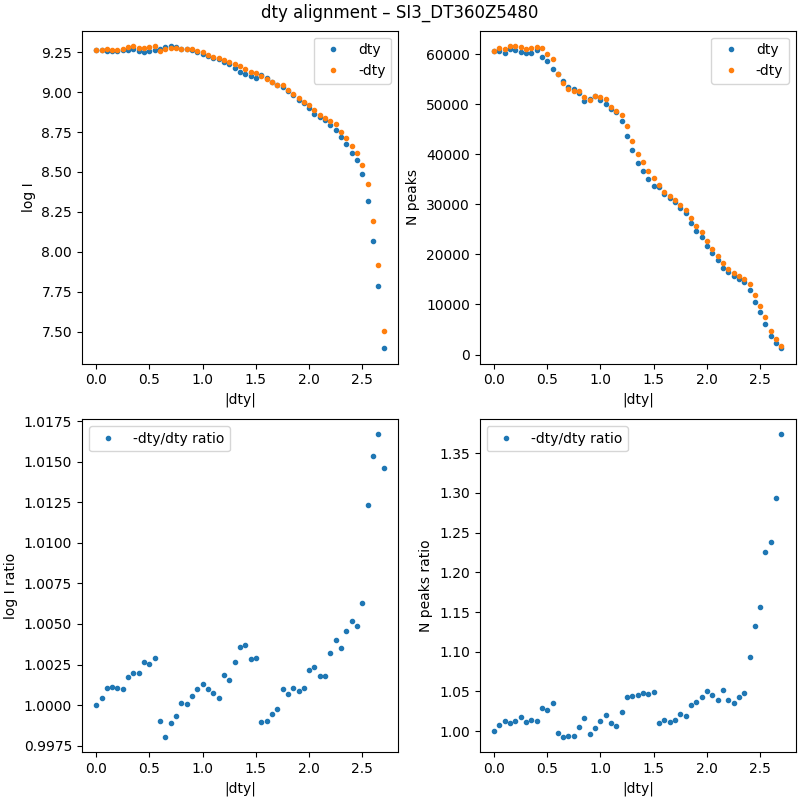

In [23]:
# check dty pairs have roughly the same number of peaks assigned. If not, there is maybe a problem
friedel_pairs.check_y_symmetry(cf, ds, saveplot=False)

For SI3_DT360Z5480, the number of peaks and total intensity match very well in each pair of scans. We also see that the total intensity and number of peaks per scan is decreasing with increasing distance from the rotation center (dty=0). This is normal, because the volume illuminated by the beam decreases toward the rim and eventially reaches zero when the beam is fully out of the sample. 

The ratios of peak number and log(intensity) oscillate around 1 for most of the y-pairs, and then deviates more significantly from 1 toward the extremity of the sample. The saw-tooth oscillations are related to the variation of beam intensity over time, which gets a refill every hour (at ESRF). This is not very problematic,as the peak ratios still remain very close to 1. If you see much larger deviations, ther eis likely a problem with the data. 

### Friedel pair labeling

Now we are ready for finding Friedel pairs. We can first try on one pair of scans, to see how it looks and tune parameters for the Friedel pair matching function.

We need to use the function label_friedel_pair from the friedel_pair module. This function searches for nearest neighbors between two symmetric scans, in a 4D space formed using two-theta, eta, omega, and intensity. mtth and mI are scaling factors for the two-theta and intensity dimensions. Tuning these two parameters allows to give more or less weight to two-theta and intensity in the identification of nearest-neighbours. See friedel_pairs.search_space docstring for more information. 

Multiple iterations of this process are run, increasing each time the distance threshold for nearest neighbor search by an increment dist_step, until distance dist_max is reached. Distance here corresponds to the euclidian distance in the 4D search space. Starting with dist_max = 1.5 and dist_step = 0.1 is usually a good starting guess, but this depends on scaling parameter mtth and mI. 

Setting doplot = True, several plots are made to evaluate the quality of pairs match.

sorting peakfile by dty scans...
3162 pairs kept out of  60717  possible matches
10775 pairs kept out of  57555  possible matches
8262 pairs kept out of  46780  possible matches
6053 pairs kept out of  38518  possible matches
4757 pairs kept out of  32465  possible matches
3616 pairs kept out of  27708  possible matches
2851 pairs kept out of  24092  possible matches
2013 pairs kept out of  21241  possible matches
2543 pairs kept out of  19228  possible matches
1746 pairs kept out of  16685  possible matches
1300 pairs kept out of  14939  possible matches
1048 pairs kept out of  13639  possible matches
782 pairs kept out of  12591  possible matches
623 pairs kept out of  11809  possible matches
581 pairs kept out of  11186  possible matches
Friedel pair matching Completed.
N pairs = 50112 out of 60717 possible candidates
Fraction of peaks matched = 0.83
Fraction of intensity matched = 0.94
dstep_max = 1.500


/home/esrf/jean1994b/pf_3dxrd/friedel_pairs.py:503: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = pl.figure(figsize=(8,10))


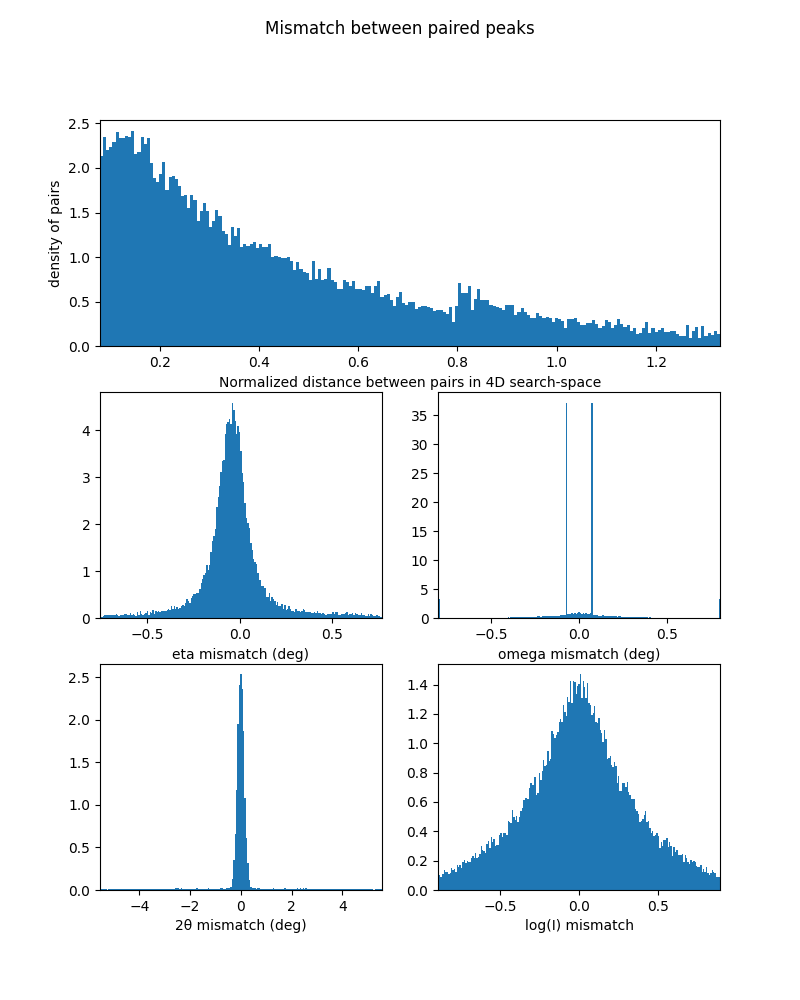

In [42]:
# select peaks from a pair
c1, c2 = friedel_pairs.select_y_pair(cf, ds, pair_id = 0)

# friedel pair search. let's try first with default values
cp = friedel_pairs.label_friedel_pairs(c1,c2,
                                  dist_max = 1.5,
                                  dist_step = 0.1,
                                  mI=1/5,
                                  mtth=1,
                                  verbose=True,
                                  doplot=True)

Let's have a look at outputs. A large proportion of peaks have been paired: 82%, corresponding to 94% of total intensity. This seems to indicate that peak match are more easily found between stronger peaks. 

The top plot shows the distribution of euclidian distance between paired peak in the 4D search space. In an ideal case, this distribution should peak at low distance and then rapidly decrease toward zero. If this is not the case, try to reduce scaling factors mtth and mI. 

Other plots show the distribution of peak mismatch along the four dimensions used to build the 4D search space: eta mismatch (in degree), omega mismatch (in degree), two-theta mismatch (in degree), and intensity mismatch (in log units). 

Large mismatch in eta and omega (>0.5°) should be considered as suspicious. Same for 2-theta, although it depends on the sample size (larger sample implies larger mismatch). Peak intensity mismatch can be quite large, especially for stronger peaks (remember that beam intensity varies a bit during acquisition), but differences larger than one order of magnitude are very dodgy. 

Reducing the value of mtth and mI usually improves the match in eta and omega, at the expense of two-theta and I (normal: by doing this you are giving more weight to eta and omega and you are relaxing the constraint on tth and I). Try to find the right balance, for which the distribution of mismatch is acceptable for each four dimensions. 


For dataset For SI3_DT360Z5480, most of the pairs look ok. However, the there is a small proportion of dodgy pairs with (large mismatch along at least one dimension). We can try to reduce a bit the dist_max threshold. 


sorting peakfile by dty scans...
3162 pairs kept out of  60717  possible matches
10775 pairs kept out of  57555  possible matches
8262 pairs kept out of  46780  possible matches
6053 pairs kept out of  38518  possible matches
4757 pairs kept out of  32465  possible matches
3616 pairs kept out of  27708  possible matches
2851 pairs kept out of  24092  possible matches
2013 pairs kept out of  21241  possible matches
2543 pairs kept out of  19228  possible matches
1746 pairs kept out of  16685  possible matches
Friedel pair matching Completed.
N pairs = 45778 out of 60717 possible candidates
Fraction of peaks matched = 0.75
Fraction of intensity matched = 0.92
dstep_max = 1.000


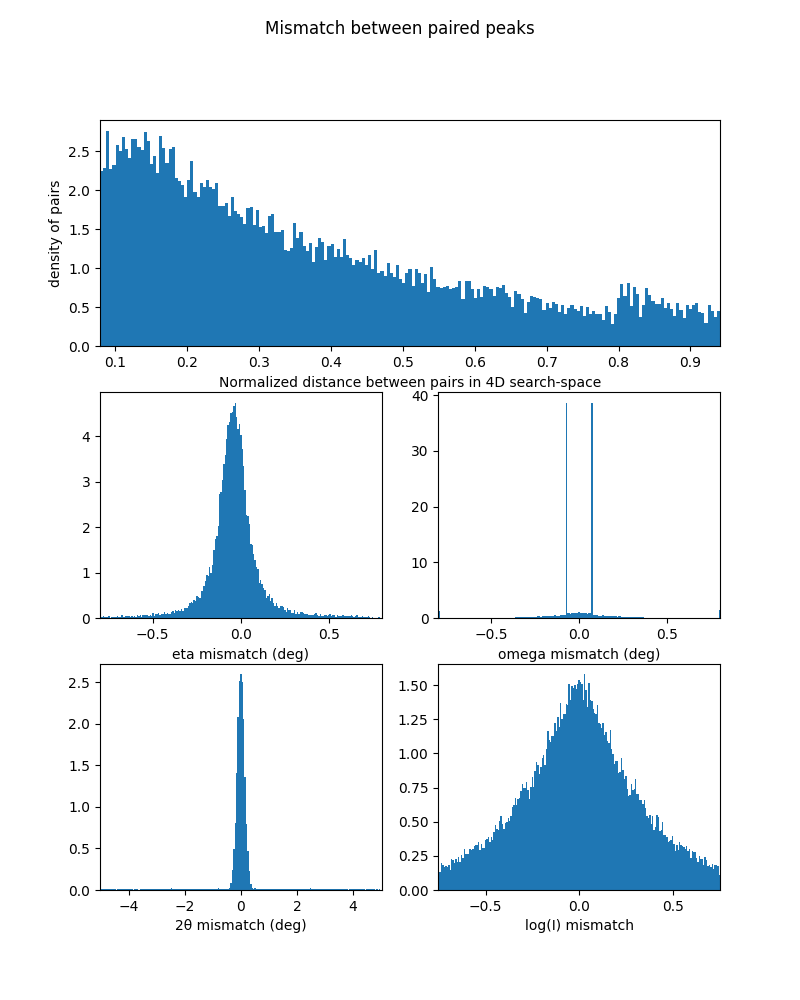

In [48]:
c1, c2 = friedel_pairs.select_y_pair(cf, ds, pair_id = 0)

cp = friedel_pairs.label_friedel_pairs(c1,c2,
                                  dist_max = 1,
                                  dist_step = 0.1,
                                  mI=1/5,
                                  mtth=1,
                                  verbose=True,
                                  doplot=True)

Once we are satisfied with the outputs, we can do the pairing on all y-pairs. For this, we will use the function find_all_pairs, which iterates label_friedel_pairs on all y-pairs in the dataset and then merges all outputs in a single columnfile. This function returns a list of paired peakfiles, which is then merged into one single peakfile using the function merge_outputs. 


NB: Doing this way, the pairing process is done using a single core. It is however quite straightforward to parallelize, for faster computation. You can use the script find_friedel_pairs.py in pf_3dxrd/scripts to run the process on multiple cores. 

Friedel pair search...


100%|██████████| 55/55 [00:29<00:00,  1.83it/s]


Updating Friedel pair labels


100%|██████████| 54/54 [00:00<00:00, 447.15it/s]


Merging peakfiles...
Friedel pair matching Completed.
N pairs =  1552990
Fraction of peaks matched = 0.76
Fraction of total intensity matched = 0.92


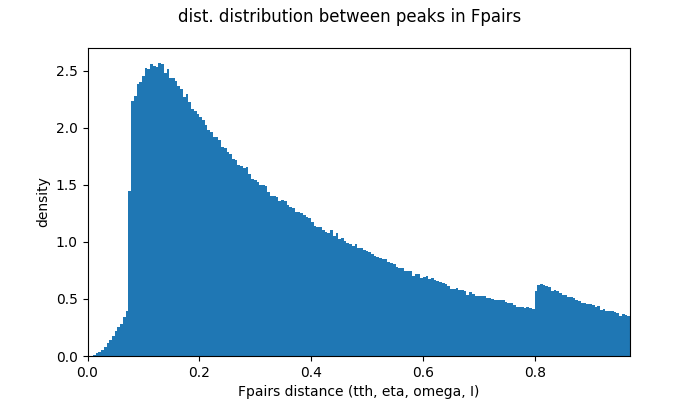

In [54]:
out = friedel_pairs.find_all_pairs(cf,
                                   ds,
                                   dist_max=1.,
                                   dist_step=0.1,
                                   mI=1/5,
                                   mtth=1)


cf_paired, fp_labels, stats = friedel_pairs.merge_outputs(out, cf, doplot=True)

Now, let's have a look at the new peakfile. It contains two new columns fp_id and fp_dist. fp_id is a unique index given to each pair. Because each pair has two peaks, each value of fp_id occurs exaclty twice. Non-paired peaks have been removed, so the peakfile contains only friedel pairs. fp_dist is the euclidian distance (in the 4D search space) between the two peaks of each pair, which has been plotted above. 

In [55]:
cf_paired.titles

['omega',
 's_raw',
 'f_raw',
 'sum_intensity',
 'spot3d_id',
 'dty',
 'number_of_pixels',
 'sc',
 'fc',
 'xl',
 'yl',
 'zl',
 'tth',
 'eta',
 'gx',
 'gy',
 'gz',
 'ds',
 'fp_id',
 'fp_dist']

In [57]:
# show the first 10 pairs. cf has been ordered by fp_id
for t in ['fp_id', 'tth', 'sum_intensity']:
    v = cf_paired.getcolumn(t)[:20]
    print(f'{t}:\n {v}')

np.all(np.equal(cf_paired.fp_id[::2], cf_paired.fp_id[1::2]))

fp_id:
 [0 0 1 1 2 2 3 3 4 4 5 5 6 6 7 7 8 8 9 9]
tth:
 [10.58794726 10.80674864 12.04591504 12.05355316  7.25722221  7.11471551
 13.34894883 13.48724413 15.65955464 15.98070907 15.09600239 15.05015915
 12.23597623 12.22544047  8.66587355  6.81798004 11.17435947 11.26313897
 12.79641217 12.78278618]
sum_intensity:
 [133285.5 137144.5   1755.5   1582.  108010.  106147.   28382.5  27742.
   6824.5   7179.     958.5   1044.5 103736.  112981.5   3803.5   3925.5
  15306.   15903.  128537.5 136677.5]


True

There is also a function to split the columnfile into two symmetrical columnfiles, each containing one peak of each pair

In [58]:
c1, c2 = friedel_pairs.split_fpairs(cf_paired)
print(f'c1: {c1.fp_id[:10]}')
print(f'c2: {c2.fp_id[:10]}')

c1: [0 1 2 3 4 5 6 7 8 9]
c2: [0 1 2 3 4 5 6 7 8 9]


Typically, the distribution of fp_dist show an asymetric shape, with a maximum close to zero and a long tail toward higher values. Ideally, you want the peak of the distribution to be close to zero, with a sharp decrease of the tail at increasing distance. 

Note however that there are no canonical rules to discriminate a "good" from a "bad" distribution. Distance changes significantly depending on on scaling parameters mtth and mI used for pairing (larger scaling factors tend to "flatten" the distribution). Sample size also has an influence, because a larger sample size implies larger two-theta mismatch.

We can select a  "low mismatch" and a "large mismatch" subsets among the friedel pairs, and plot the difference in eta, two-theta, etc.

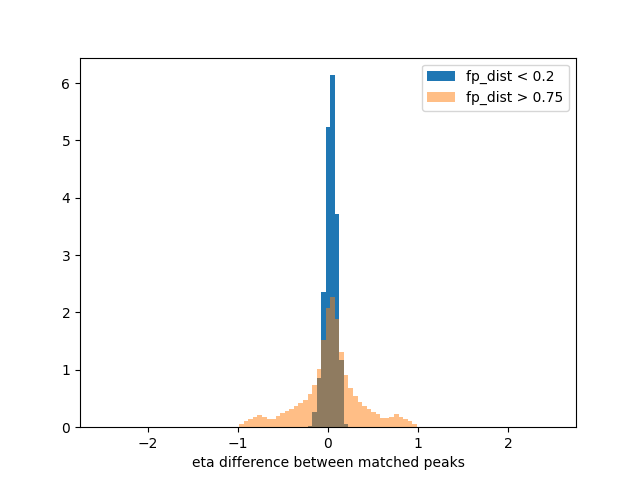

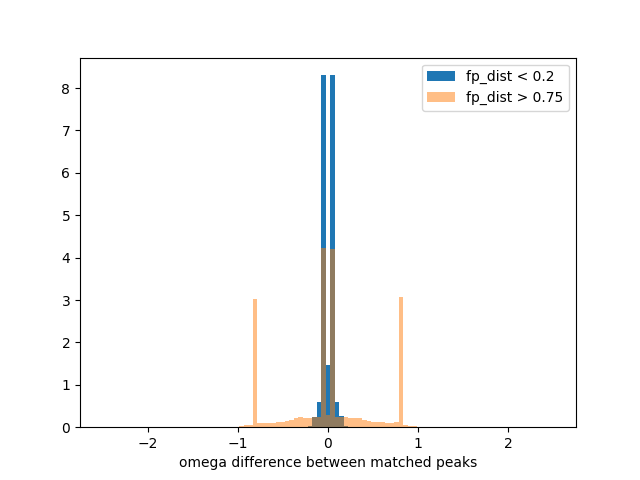

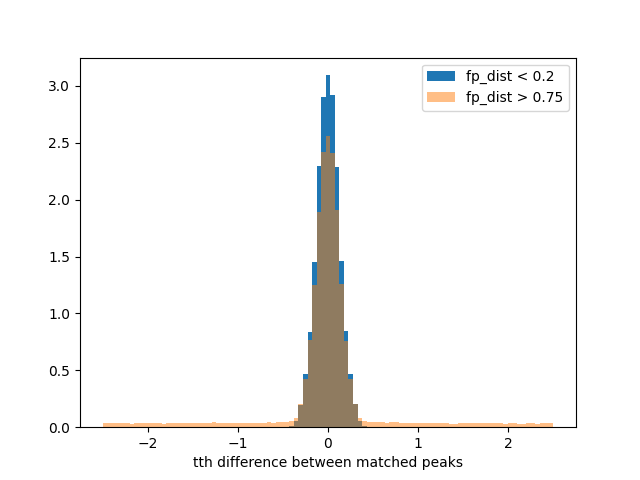

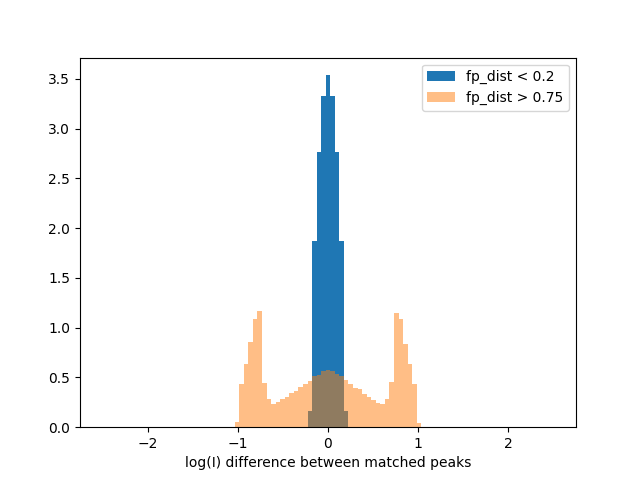

In [66]:
c1, c2 = friedel_pairs.split_fpairs(cf_paired)
dlow, dhigh = 0.2, 0.75
m = c1.fp_dist < dlow
m2 = c1.fp_dist > dhigh


pl.figure()
pl.hist(c1.eta[m]%360 - (180-c2.eta[m])%360,bins=np.linspace(-2.5,2.5,100), density=True, label=f'fp_dist < {dlow}');
pl.hist(c1.eta[m2]%360 - (180-c2.eta[m2])%360,bins=np.linspace(-2.5,2.5,100), alpha=.5, density=True, label = f'fp_dist > {dhigh}');
pl.xlabel('eta difference between matched peaks')
pl.legend()


pl.figure()
pl.hist(c1.omega[m]%360 - (180+c2.omega[m])%360,bins=np.linspace(-2.5,2.5,100), density=True, label=f'fp_dist < {dlow}');
pl.hist(c1.omega[m2]%360 - (180+c2.omega[m2])%360,bins=np.linspace(-2.5,2.5,100), alpha=.5, density=True, label = f'fp_dist > {dhigh}');
pl.xlabel('omega difference between matched peaks')
pl.legend()


pl.figure()
pl.hist(c1.tth[m] - (c2.tth[m]),bins=np.linspace(-2.5,2.5,100), density=True, label=f'fp_dist < {dlow}');
pl.hist(c1.tth[m2] - (c2.tth[m2]),bins=np.linspace(-2.5,2.5,100), alpha=.5, density=True, label = f'fp_dist > {dhigh}');
pl.xlabel('tth difference between matched peaks')
pl.legend()


pl.figure()
pl.hist(np.log10(c1.sum_intensity[m]) - np.log10(c2.sum_intensity[m]),bins=np.linspace(-2.5,2.5,100), density=True, label=f'fp_dist < {dlow}');
pl.hist(np.log10(c1.sum_intensity[m2]) - np.log10(c2.sum_intensity[m2]),bins=np.linspace(-2.5,2.5,100), alpha=.5, density=True, label = f'fp_dist > {dhigh}');
pl.xlabel('log(I) difference between matched peaks')
pl.legend()


We see that large fp_dist corresponds mostly to pairs with unrealistic mismatch in sumI and omega (to a lesser extent). However, the large fp_dist subset also contains some "good" peaks, ie. there is a tradeoff between completeness vs. accuracy of pairing: using a low dist_max threshold, you get mostly accurate pairs at the expense of completeness. Uisng  larger dist_max threshold, you increase completeness at the exepense of accuracy. 

IMHO it is better to favorize completeness at this stage, because there are several ways to clean up the peakfile during subsequent processing steps. 

### Geometry correction
Now we have friedel pairs labeled, we can exploit them in a useful way. Basically, there are two pices of information you can retrive from Friedel pairs:

- the offset from the rotation center
- the correct scattering angle tth_c

If a grain is not on the rotation centre but translated by an offset $t(d_x, d_y, d_z)$ from the center, this will result in an offset on the detector and inaccurate 2-theta and eta values. In a classic indexing procedure, $t$, eta and 2-theta are fitted *à-posteriori*, after a first round of indexing. With Friedel pairs, we can do this before, which will make indexing much easier.

For a scanning 3DXRD acquisition using a thin pencil beam, the beam dimension in y and z is small. Therefore, we can consider that offset only occurs along the beam direction, ie. along the x-axis. This means that only 2-theta (tth) is modified by this offset, not eta. We also know $d_y$, which is basically the translation along the y-direction during scanning, which is given by in the value in the dty column. With these assumptions, we find that for two peaks (p1,p2) forming a Friedel pair:

- $2θ_{cor}$ = 1/2.(tan1 + tan2)
- $d_x$ = L . (tan1-tan2)/(tan1+tan2)

where tan1 and tan2 are respectively tan($2θ_1$) and tan($2θ_2$) of p1 and p2 and L the detector distance from the rotation center. Thus, we get $2θ_{cor}$, the "real" scattering angle accounting only for d-spacing, independent from the offset dx.

Furthermore, we can use $d_x$ to relocate the peak in the sample reference frame. We already known $d_y$, so we just need to apply a back-rotation of angle $\omega$ to the coordinates ($d_x$, $d_y$) to get coordinates in the reference frame of the sample: 

$(x_s,y_s) = R_{\omega}.(d_x,d_y)$

These geometric corrections are done using the function update_geometry_s3dxrd from the friedel_pairs module.

In [68]:
friedel_pairs.update_geometry_s3dxrd(cf_paired, ds, update_gvecs=True) 
cf_paired.titles

['omega',
 's_raw',
 'f_raw',
 'sum_intensity',
 'spot3d_id',
 'dty',
 'number_of_pixels',
 'sc',
 'fc',
 'xl',
 'yl',
 'zl',
 'tth',
 'eta',
 'gx',
 'gy',
 'gz',
 'ds',
 'fp_id',
 'fp_dist',
 'tthc',
 'dsc',
 'xs',
 'ys',
 'r_dist']

New columns have been computed:
- tthc: corrected two-theta
- dsc: corrected d-spacing (in Å-1)
- (xs,ys): relocated peak position in the reference frame of the sample
- r_dist: radial distance of the peak source from the rotation center (independant from omega)

Now let's have a look on the data. We can first try to compare 2-theta before and after correction

Text(0, 0.5, 'pdf')

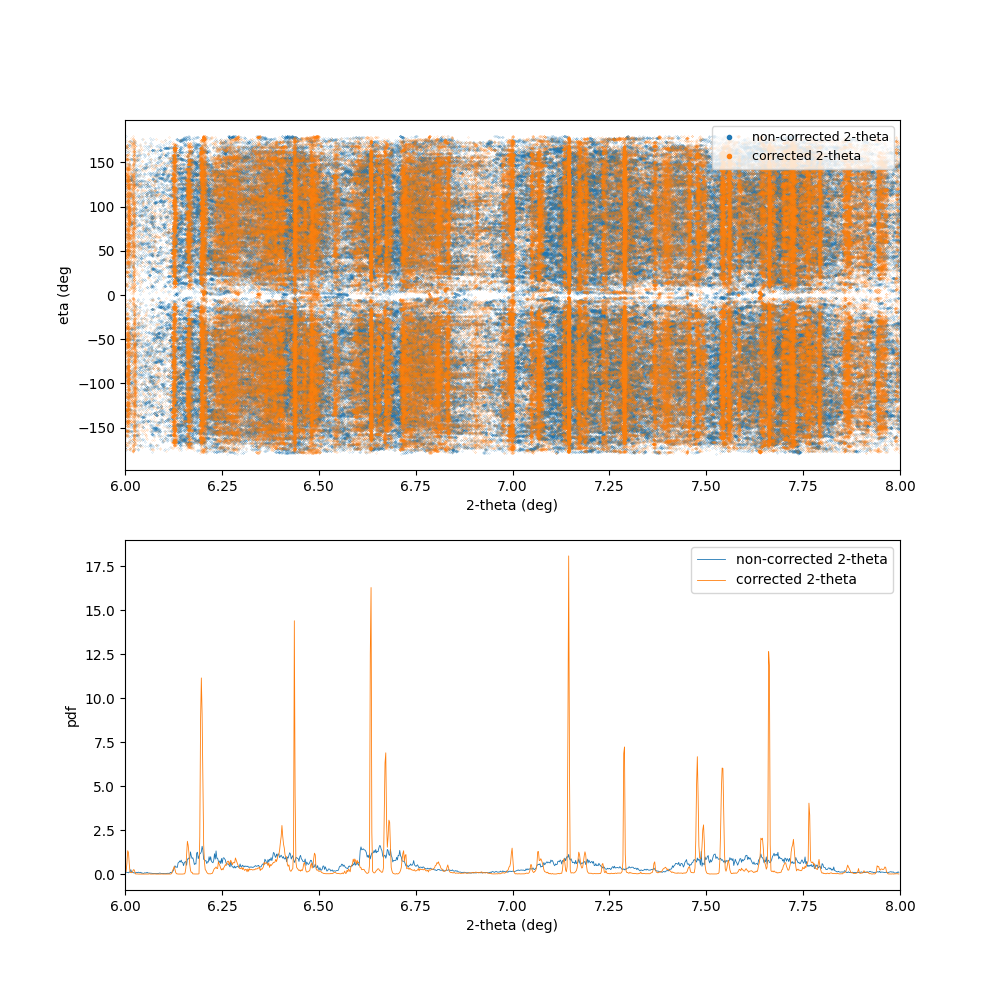

In [69]:
# plot 2-theta vs. eta for corrected vs non-corrected tth on a subset of the two-theta range
tthmin, tthmax = 6,8

fig = pl.figure(figsize=(10,10))
fig.add_subplot(211)
pl.plot(cf_paired.tth, cf_paired.eta, '.', ms = .2, label='non-corrected 2-theta') 
pl.plot(cf_paired.tthc, cf_paired.eta, '.', ms=.2, label='corrected 2-theta')
pl.xlabel('2-theta (deg)')
pl.ylabel('eta (deg')
pl.xlim(tthmin, tthmax)
pl.legend(markerscale=30, loc='upper right', fontsize=9) 

# 2-theta histogram for corrected vs non-corrected peaks
fig.add_subplot(212)
h,b,_ = utils.compute_tth_histogram(cf_paired, use_tthc = False, tthmin=tthmin, tthmax = tthmax, tthstep = 0.002,
                                    uself = True, doplot=False, density=True)
hc,bc,_ = utils.compute_tth_histogram(cf_paired, use_tthc = True, tthmin=tthmin, tthmax = tthmax, tthstep = 0.002,
                                      uself = True, doplot=False, density=True)

pl.plot(b,h,'-', lw=.6, label='non-corrected 2-theta')
pl.plot(bc,hc,'-',lw=.6, label='corrected 2-theta')
pl.legend()
pl.xlim(tthmin, tthmax)
pl.xlabel('2-theta (deg)')
pl.ylabel('pdf')


#### Comparison with computed hkl rings

There is a sharp reduction of the 2-theta spread using corrected peak coordinates, and we see some peaks appearing in the distribution. Now we want to see if these peaks match with predicted Bragg peaks for the different phases in the sample. 

For this we need to compute the theoretical two-theta position of these peaks for each phase in the sample. This can be done by using ImageD11 functions and loading multiple parameter files. However, this rapidly becomes impractical when the sample contains more than one or two phases.

Instead, we will use the module crystal_structure.py from pf_3dxrd. This module is built upon other python packages for X-ray diffraction data, namely diffpy.structure, Dans_Diffraction and orix. It defines a class CS (for crystal_structure), which allows to store crystal structure information directly loaded from a cif file.

For simplicity, we assume that we already know what are the phases in the sample, and directly provide crystal structures as cif files. However, depending on your sample, some phases might be unknown and need to be determined beforehand. If this is the case, you can use the  the following strategy:
- export the histogram of corrected $2θ$ to an ascii file. 
- import this file in your favorite powder diffraction analysis software, where the two-theta spectrum can be compared to a database of known crystal structures. Once each major phase has been identified, you can try Le Bail or Rietveld refinement to fit more precisely the average lattice parameters. Having a good fit of these lattice parameters is important, because it will determine how accurately you can pick up diffraction peaks from a given crystal structure, using two-theta thresholds around each Bragg peak computed from the fitted unit cell.


In [70]:
# let's define a dictionary with all our phases. l
phase_names = ['quartz', 'orthoclase', 'oligoclase', 'biotite', 'magnetite']
phase_dict = {}

# load crystal structures from cif files. They should all be in the /cif folder
for i,p in enumerate(phase_names):
    cs = crystal_structure.load_CS_from_cif(cif_path = f'cif/{p}.cif', name=p, pid=i)
    print(cs)
    phase_dict[p] = cs

CS: quartz, phase_id: 0, spg: P3221, spg_no: 154, lattice: [  4.91325   4.91325   5.41206  90.       90.      120.     ]
CS: orthoclase, phase_id: 1, spg: C1-11, spg_no: 12, lattice: [  8.589  13.013   7.197  90.    116.02   90.   ]
CS: oligoclase, phase_id: 2, spg: C-1, spg_no: 2, lattice: [  8.154  12.823   7.139  94.06  116.5    88.59 ]
CS: biotite, phase_id: 3, spg: C12/m1, spg_no: 12, lattice: [  5.355   9.251  10.246  90.    100.15   90.   ]
CS: magnetite, phase_id: 4, spg: Fd3m, spg_no: 227, lattice: [ 8.3965  8.3965  8.3965 90.     90.     90.    ]


We want to compute theoretical 2-theta positions of Bragg peaks for all these phases. It is possible to get directly these values with ImageD11.unitcell, but we will use a bit more fancy way here, which happens to be quite usefull when dealing with complex mixtures of low-symmetry phases: first, we compute a simulated powder spectrum for each phase. Then, we run a peaksearch on this spectrum (using scipy.signal) to find the N-strongest peaks. This allows to retain only the most significant peaks, and ignore the numerous, very low intensity peaks which theoretically exist but are practically barely visible.

Scatter(quartz with 2 atomic positions, 6 symmetries)
       Type: x-ray
     Energy: 43.57356018082551 keV
 Wavelength: 0.28454050670689945 A
 ---Settings---
      Powder units: tth
    Isotropic ADPs: True
  Specular Direction (reflection): ( 0, 0, 1)
Parallel Direction (transmission): ( 0, 0, 1)
      theta offset: 0.0
         min theta: -180.0
         max theta: 180.0
      min twotheta: 2
      max twotheta: 15
 ---X-Ray Settings---
 Waasmaier scattering factor: False
 ---Magnetic Settings---
   Mag. scattering: True
  Mag. form factor: True
         Polarised: False
      Polarisation: sp
       Pol. vector: (0,1,0)
 ---Resonant Settings---
   Azimuthal angle: 0
    Azimuthal ref.: (1,0,0)
               flm: (0,1,0)
  use e1e1 approx.: True

Scatter(orthoclase with 18 atomic positions, 4 symmetries)
       Type: x-ray
     Energy: 43.57356018082551 keV
 Wavelength: 0.28454050670689945 A
 ---Settings---
      Powder units: tth
    Isotropic ADPs: True
  Specular Direction (refl

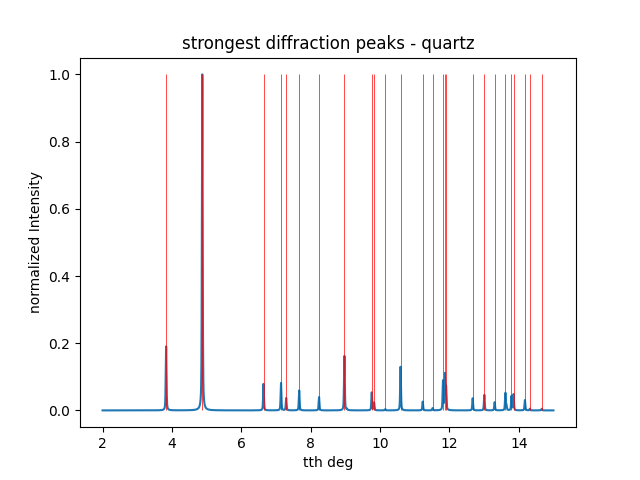

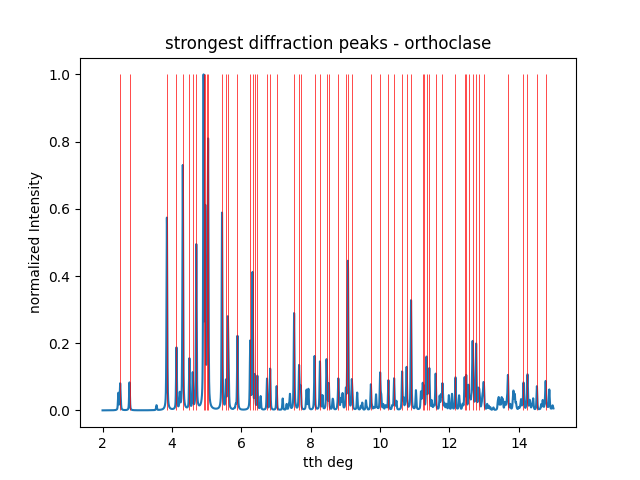

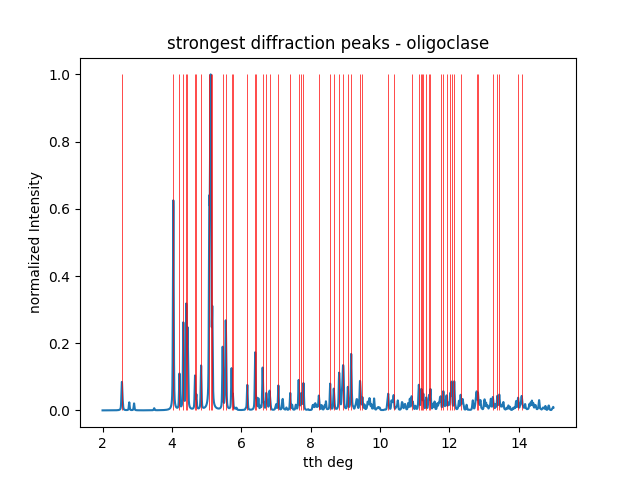

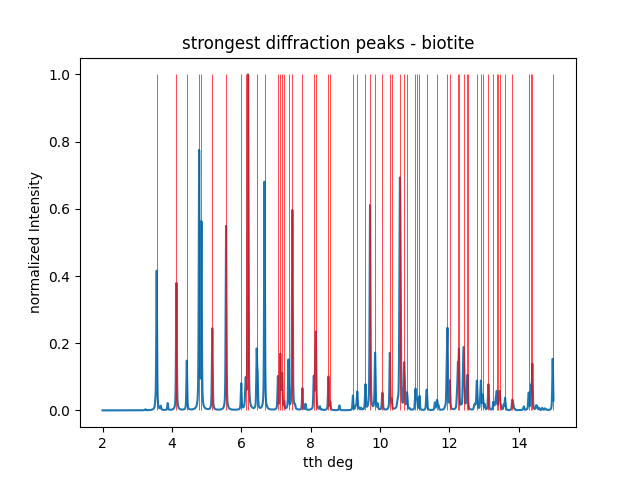

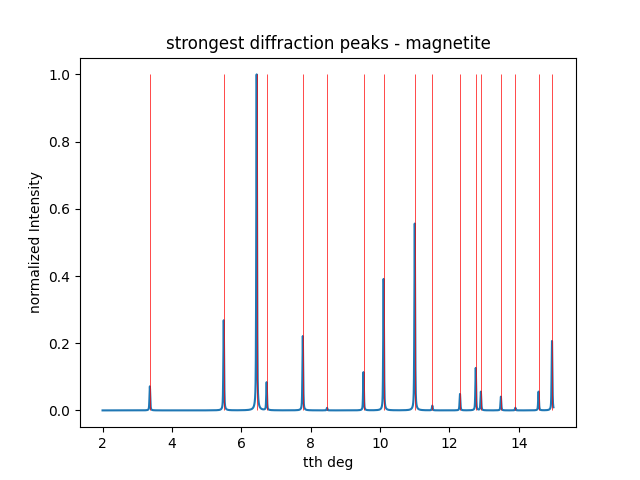

In [71]:
wl = cf.parameters.get('wavelength')  # X-ray wavelength

for cs in phase_dict.values():
    # simulated powder spectrum
    cs.compute_powder_spec(wl, min_tth=2, max_tth=15, doplot=False)
    
    # peak search in the powder spectrum. Imin is the min intensity relative to the strongest peak. 
    # prominence measures how much a peak stands out from the surrounding baseline of the signal (cf scipy.signal)
    cs.find_strongest_peaks(Imin=0.001, prominence=0.001, Nmax=60, doplot=True) 

Now we can replot the data with these theoretical peaks

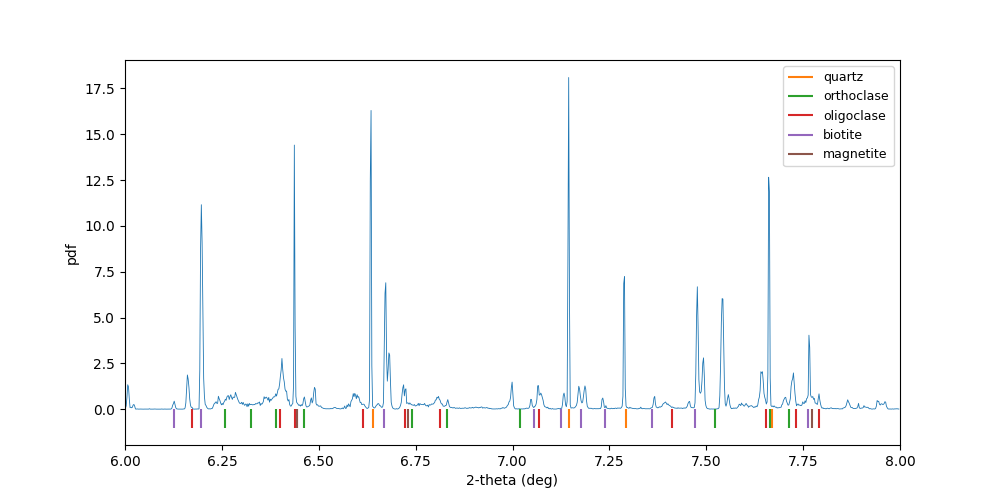

In [72]:
# replot 2θ vs η and add computed hkl ring positions for each phase
colors = pl.matplotlib.cm.tab10.colors

pl.figure(figsize=(10,5))
pl.plot(bc,hc, '-', lw=.6)

for p,cs in phase_dict.items():
    pl.vlines(cs.strong_peaks[0], -1,0, colors = colors[cs.phase_id+1], label=p)
pl.xlabel('2-theta (deg)')
pl.ylabel('pdf')
pl.xlim(tthmin, tthmax)

pl.legend(loc='upper right', fontsize=9) 

The match between theoretical Bragg peaks and real eaks in the distribution looks pretty good, at least for quartz.
There is a slight mismatch especially for orthoclase and oligoclase. These phases are problematic because they are not pure compounds but form solid solutions, with significant variation of the lattice parameters with composition. 

### Sample reconstruction

There is a last thing we can do in this first part of the tutorial. In addition to corrected 2-theta, we also have the $(x_s,y_s)$ coordinates of each diffraction peaks in the sample reference frame. Let's try to plot these data in a 2D histogram

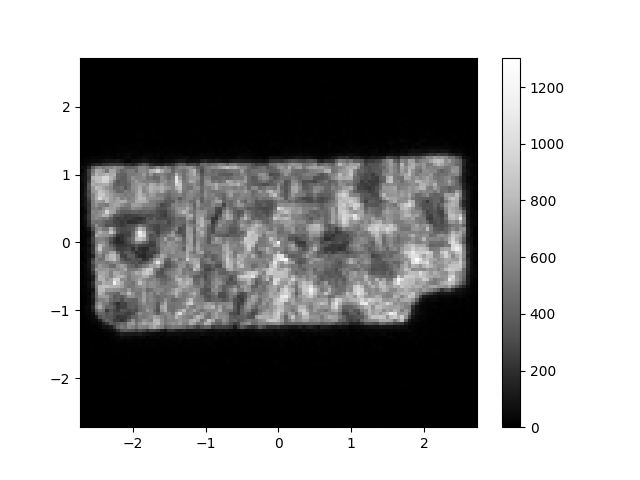

In [73]:
pl.figure()
cmap = pl.matplotlib.cm.Greys_r.copy()
cmap.set_extremes(under='k', over='w')

pl.hist2d(cf_paired.xs, cf_paired.ys, bins = ds.ybinedges, cmap=cmap);
pl.colorbar()

And we get a nice map of the sample! We can filter out peaks outside the ROI, to keep only portions of the map with complete data

In [74]:
cf_paired.filter(cf_paired.r_dist <= ds.ybinedges.max())

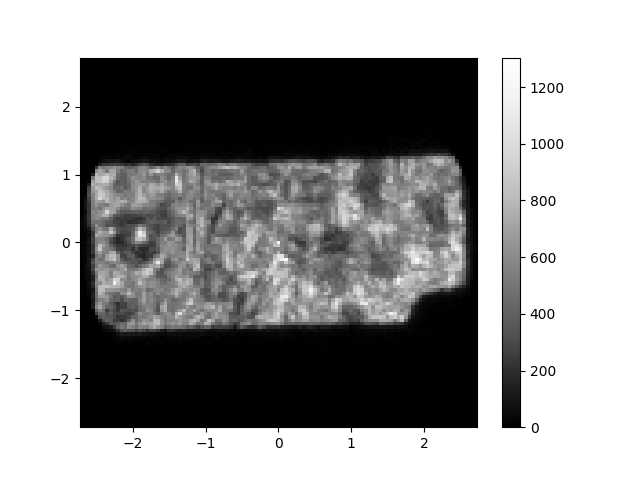

In [75]:
pl.figure()

pl.hist2d(cf_paired.xs, cf_paired.ys, bins = ds.ybinedges, cmap=cmap);
pl.colorbar()

There is also a function in the utils module to make this plot. It allows to select subsets of peaks for plotting, e.g, a small rectangular ROI in the sample, or a subset corresponding to one single phase. Let's try it with quartz.

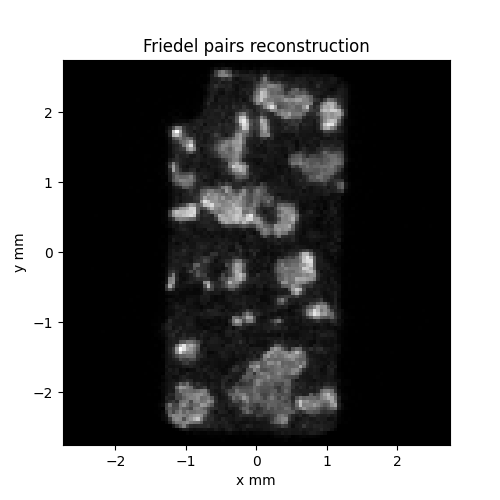

In [76]:
# compute mask for quartz. select_tth_rings returns a mask with all peaks within a certain distance of theoretical tth rings for quartz.
# see doctstring for more info.
mask_qtz = utils.select_tth_rings(cf_paired, phase_dict['quartz'].strong_peaks[0], tth_tol=0.02, tth_max=15, is_sorted=False)

kw = {'cmap':'Greys_r'}   # keyword arguments to pass to plot function

# plot reconstruction for quartz peaks only
utils.friedel_recon(cf_paired,
                    xbins = ds.ybinedges,
                    ybins = ds.ybinedges,
                    doplot=True,
                    mask = mask_qtz,
                    weight_by_intensity=True,
                    norm = True,
                    **kw );

We clearly see the quartz grains appearing, but there is still some background signal from outside of these grains. This results either from dodgy Friedel pairs which were wrongly relocated, or from overlaps between different Bragg peaks from different phases, which inevitably results in wrong selection of some peaks. In the next tutorial, we will see how we can improve that and make a better phase map. 

### Save peakfile

To finish, we need to save these data. We will create a new peakfile "datasetname_pks_p.h5", to avoid overwriting the raw peak file

There is a function in ImageD11.columnfile to export columnfiles, but we will use here the custom function from the pf_3dxrd.utils module, which does basically the same but make sure that essential information on Friedel pairs (namely, fp_id and fp_dist) are saved. 

In [94]:
# save data. The 'minimal' save mode means that only the necessary data columns are kept. All data that can be recomputed from other columns are dropped.
utils.colf_to_hdf(cf_paired, os.path.join(data_dir, dsname+'_pks_p.h5'), save_mode='minimal')